In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

## Load Rain Extremes object and collect data

In [2]:
from ProcessingMCS import ProcessMCS
Re = ProcessMCS()

entire map 8480824.673795126
tranche de latitude :  424041.2336897563
tranche de longitude :  265025.7710560977
s 13251.288552804885
DYAMOND 130E_165E_0N_20N SAM
<xarray.Dataset>
Dimensions:            (lat: 518, lon: 896, lat_global: 20, lon_global: 32,
                        days: 14)
Coordinates:
  * lat                (lat) float32 0.01931 0.05794 0.09657 ... 19.95 19.99
  * lon                (lon) float32 130.0 130.1 130.1 ... 164.9 164.9 165.0
  * lat_global         (lat_global) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * lon_global         (lon_global) int64 0 1 2 3 4 5 6 ... 25 26 27 28 29 30 31
  * days               (days) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    pixel_surf         (lat, lon) float64 ...
    global_pixel_surf  (lat_global, lon_global) float64 ...
    mean_prec          (lat_global, lon_global, days) float64 ...
    max_prec           (lat_global, lon_global, days) float64 ...
    PW_MCS             (lat_global, lon_global, days) float6

In [3]:
Prec_max = Re.ds['max_prec'].values.flatten()
Prec_mean = Re.ds['mean_prec'].values.flatten()

In [4]:
#Compute Distribution for Prec_max

dist_Prec_max = cs.Distribution(name="Dyamond Max Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_Prec_max.computeDistribution(sample = Prec_max)
dist_Prec_max.storeSamplePoints(sample = Prec_max)

dist_Prec_mean = cs.Distribution(name="Dyamond Mean Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_Prec_mean.computeDistribution(sample = Prec_mean)
dist_Prec_mean.storeSamplePoints(sample = Prec_mean)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


## Mean Max Density 



In [13]:
def computeNormalizedDensity(self, sample1, sample2, data = None, verbose = False):

    if sample1.shape != sample2.shape : ## here assume sample 1 has bigger 
        sameShape = False
        ratio_t, ratio_y, ratio_x = int(sample1.shape[0]/sample2.shape[0]), int(sample1.shape[1]/sample2.shape[1]), int(sample1.shape[2]/sample2.shape[2])
    else : 
        sameShape = True
        ratio_t, ratio_y, ratio_x = 1,1,1

    l1, l2 = len(self.bins1), len(self.bins2)

    digit1 = np.digitize(sample1, self.bins1, right = True)
    digit2 = np.digitize(sample2, self.bins2, right = True)
    #if verbose : print(digit1, digit2)
    N1 = [np.sum(digit1==i1) for i1 in range(l1)]
    N2 = [np.sum(digit2==i2) for i2 in range(l2)]
    Ntot = sample1.size
    with np.errstate(divide='ignore'):
        Norm = Ntot / np.outer(N1, N2)
    Norm[np.isinf(Norm)] = 0

    self.density = np.zeros(shape = (l1, l2))
    if data is not None : data_over_density = np.zeros(shape=(l1,l2))

    if sameShape :
        for i2 in range(l2): 
            idx = tuple(np.argwhere(digit2==i2).T)
            self.density[:, i2] = np.bincount(digit1[idx], minlength=l1)

            if data is not None: 
                for i1 in range(l1):
                    data_idx = tuple(np.argwhere((digit1==i1) & (digit2==i2)).T)
                    if len(data_idx)>0 :
                        data_over_density[i1, i2] = np.nanmean(data[data_idx])
                    else : data_over_density[i1, i2] = 0

        self.density *= Norm

    if data is not None : return data_over_density
    else : return self.density/Norm/Ntot, 1/Norm, N1, N2, Ntot


In [14]:
jd_Mean_Max_IL = cs.JointDistribution(name='Mean vs Max',distribution1=dist_Prec_mean, distribution2=dist_Prec_max)
P_Cap, Norm, Ni, Nj, Ntot= computeNormalizedDensity(jd_Mean_Max_IL, Prec_mean, Prec_max, data = None)

/scratchx/mcarenso/ipykernel_234459/2358718108.py:40: RuntimeWarning: invalid value encountered in true_divide
  else : return self.density/Norm/Ntot, 1/Norm, N1, N2, Ntot
/scratchx/mcarenso/ipykernel_234459/2358718108.py:40: RuntimeWarning: divide by zero encountered in true_divide
  else : return self.density/Norm/Ntot, 1/Norm, N1, N2, Ntot


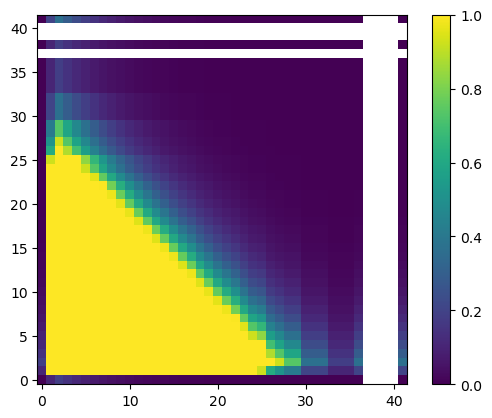

In [15]:
Nij = np.outer(Ni, Nj)
plt.imshow(Norm, vmin = 0, vmax = 1, origin = 'lower')
plt.colorbar()

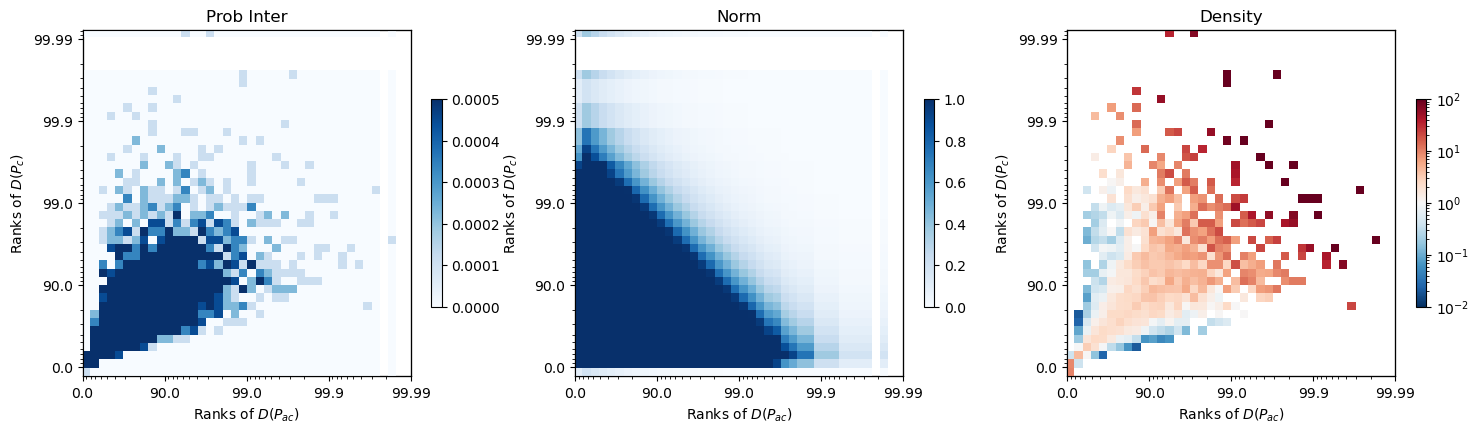

In [24]:
fig,axs = plt.subplots(ncols = 3, nrows =1, figsize=(18,4.5))
vmins = [0,0,1e-2]
vmaxs = [0.0005,1,1e2]
scales = ['linear','linear','log']
cmaps = ['Blues','Blues','RdBu_r']
legends = ['Prob Inter', 'Norm', 'Density']
i=0
for Z, ax, vmin, vmax, scale, cmap, legend in zip([P_Cap, Norm, jd_Mean_Max_IL.density], axs, vmins, vmaxs, scales, cmaps, legends) : 
    ax_show = ax.twinx().twiny()
    ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Ranks of $D(P_{ac})$", ylabel = "Ranks of $D(P_c)$") ## the given ax object must not be ax_show. 

    h = showJointHistogram(ax_show, Z.T, scale = scale, vmin = vmin,vmax =vmax, cmap = cmap)
    
    cbar = fig.colorbar(h, ax=ax, shrink=0.6)  # Adjust the "shrink" value as needed
    ax.set_title(legend)

plt.show()


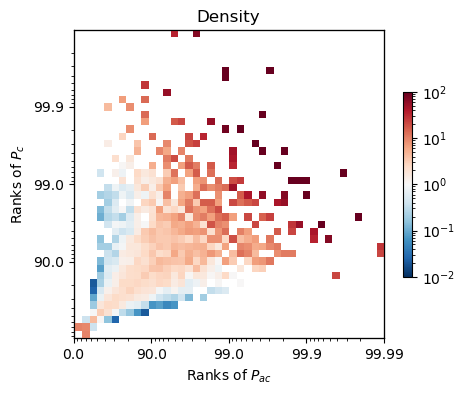

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
vmin = 1e-2
vmax = 1e2
scale = 'log'
cmap = 'RdBu_r'
legend = 'Density'

ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Ranks of $P_{ac}$", ylabel = "Ranks of $P_c$") ## the given ax object must not be ax_show. 

h = showJointHistogram(ax_show, Z.T, scale = scale, vmin = vmin,vmax =vmax, cmap = cmap)

cbar = fig.colorbar(h, ax=ax, shrink=0.6)  # Adjust the "shrink" value as needed
ax.set_title(legend)

plt.show()

## Precipitable Water 

In [10]:
Mean_Max_Jd_PW_MCS= jd_Mean_Max_IL.computeNormalizedDensity(Prec_mean, Prec_max, data = Re.ds['PW_MCS'].values.flatten())

/home/mcarenso/code/conditional-stats/src/conditionalstats.py:1126: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data[data_idx])


Text(0.5, 1.0, 'Precipitable Water in MCS')

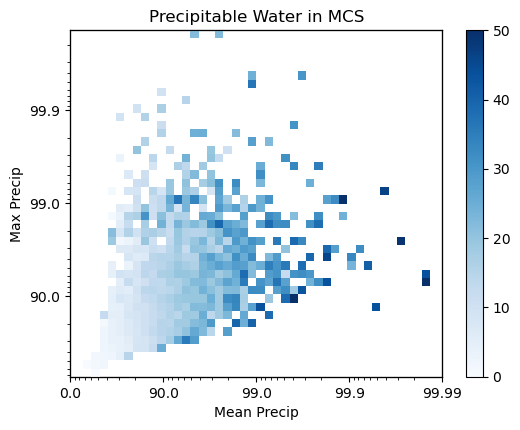

In [11]:
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

Z = Mean_Max_Jd_PW_MCS.T
h = showJointHistogram(ax_show, Z, scale = 'linear',  vmin = 0, vmax = 50, cmap = 'Blues')
plt.colorbar(h)
plt.title("Precipitable Water in MCS")

## Convergence of wind flux

In [12]:
Mean_Max_Jd_WC_MCS = jd_Mean_Max_IL.computeNormalizedDensity(Prec_mean, Prec_max, data = Re.ds['WindConv_MCS'].values.flatten())

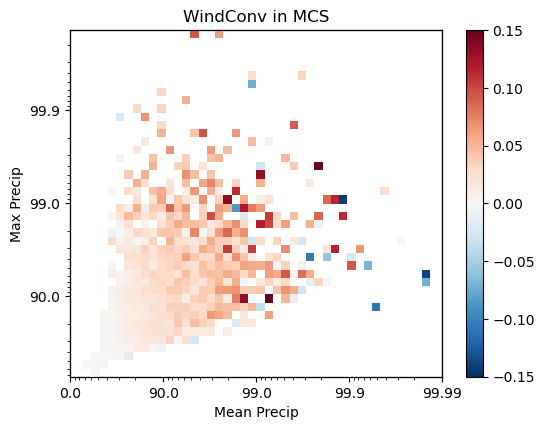

In [13]:
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

Z = Mean_Max_Jd_WC_MCS.T
h = showJointHistogram(ax_show, Z, scale = 'linear',  vmin = -0.15, vmax = 0.15, cmap = 'RdBu_r')
plt.title("WindConv in MCS")
plt.colorbar(h)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


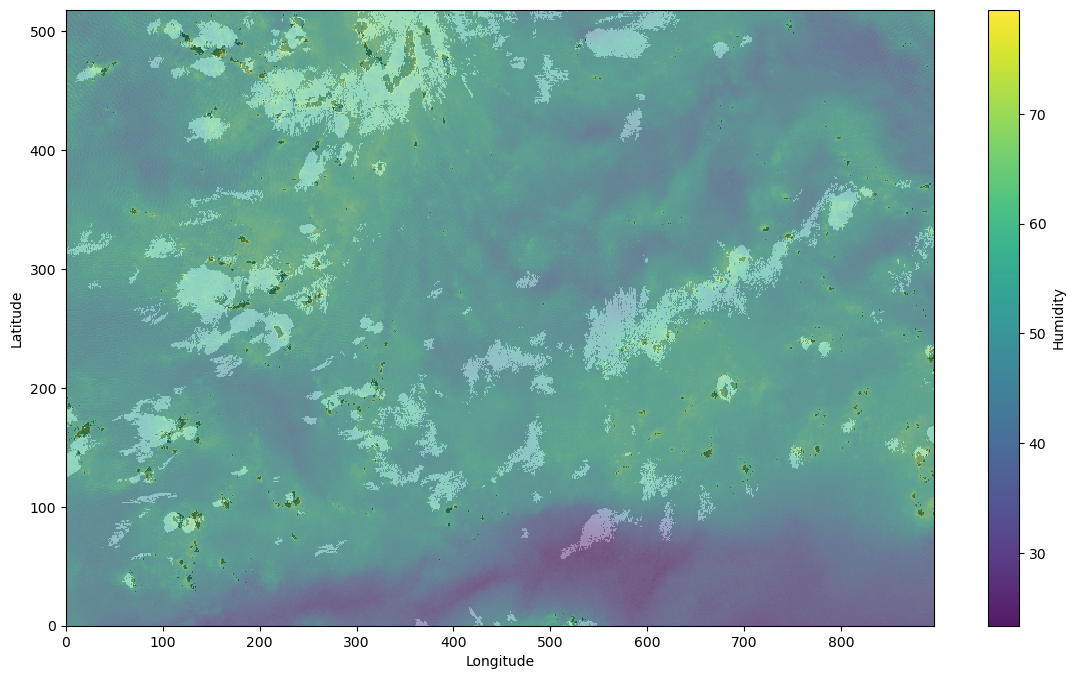

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 8))

i_t = 200

Z = Re.loadPW(i_t)
Precip = Re.loadPrec(i_t)
Grey = Re.loadLabels(i_t)

plt.pcolormesh(Z, cmap='viridis', alpha=0.9, figure = fig)
plt.colorbar(label='Humidity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Grey = np.where(np.isnan(Grey), 1, 0)
plt.pcolormesh(Grey, cmap='Greys', alpha=0.25, figure = fig, label = 'MCS')

threshold_value = np.percentile(Precip, 99)
precip_dots = np.where(Precip > threshold_value, 1, 0)
plt.pcolormesh(precip_dots, cmap='Greys', alpha=0.25, figure = fig, label = 'P_99')

plt.show()


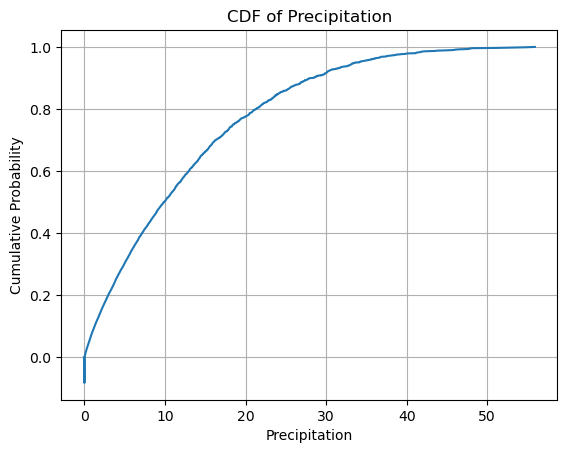

In [15]:
Precip = Precip.values.flatten()

# Assuming `Precip` is already defined and contains the precipitation data

# Calculate the CDF
sorted_precip = np.sort(Precip)
cumulative_prob = np.cumsum(sorted_precip) / np.sum(sorted_precip)

# Plot the CDF
plt.plot(sorted_precip, cumulative_prob)
plt.xlabel('Precipitation')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Precipitation')
plt.grid(True)
plt.show()


In [16]:
stringSST = "300"
sim = 'SAM'

if sim == "SAM" :     
    file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
    file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'
    sim_path = '/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_1.nc'
    output_path = "/homedata/mcarenso/Stage2023/SAM/"+stringSST+"K/"
    
elif sim == "MESONH":
    file_seg='/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_MESONH_large300_2D_irtb.nc'
    file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-MESONH_large300_2D_irtb.dat.gz'
    sim_path = '/bdd/MT_WORKSPACE/MCS/RCE/MESONH/INPUTS/v2023_05/MESONH_RCE_large300_2D_pr.nc'
    output_path = "/homedata/mcarenso/Stage2023/MESONH/"+stringSST+"K/"

elif sim == "ICON":
    file_seg = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_ICON_large300_2D_irtb.nc'
    file_tracking = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-ICON_large300_2D_irtb.dat.gz' #'/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-ICON_large300_2D_irtb.dat.gz' 
    sim_path = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/INPUTS/v2023_05/ICON_RCE_large300_2D_pr.nc'
    output_path = "/homedata/mcarenso/Stage2023/ICON/"+stringSST+"K_no_filter/"

In [17]:
import numpy as np
import matplotlib.pyplot as plt

i_t = 500


Z = xr.open_dataset(sim_path, decode_times=False)["PW"]
Z = Z.values[i_t,:,:]

Precip = xr.open_dataset(sim_path, decode_times=False)["Prec"]
Precip = Precip.values[i_t,:,:]


Grey = xr.open_dataarray(file_seg, decode_times=False)
Grey = Grey.values[i_t,:,:]


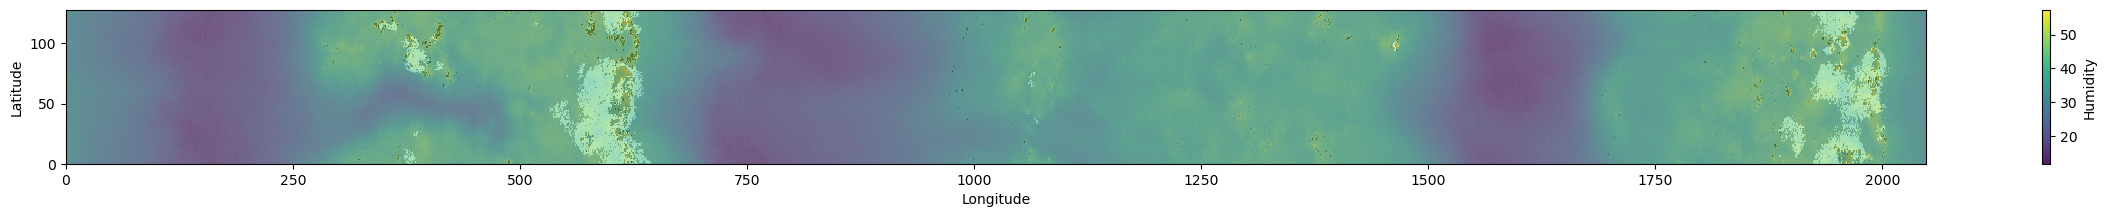

In [18]:
fig = plt.figure(figsize=(30, 2))

plt.pcolormesh(Z, cmap='viridis', alpha=0.9)
plt.colorbar(label='Humidity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Grey = np.where(np.isnan(Grey), 1, 0)
plt.pcolormesh(Grey, cmap='Greys', alpha=0.25)

threshold_value = np.percentile(Precip, 99)
precip_dots = np.where(Precip > threshold_value, 1, 0)
plt.pcolormesh(precip_dots, cmap='Greys', alpha=0.25)

plt.show()

## Max Precip attribution and grid surface verification

(518, 896)
[0. 1.]


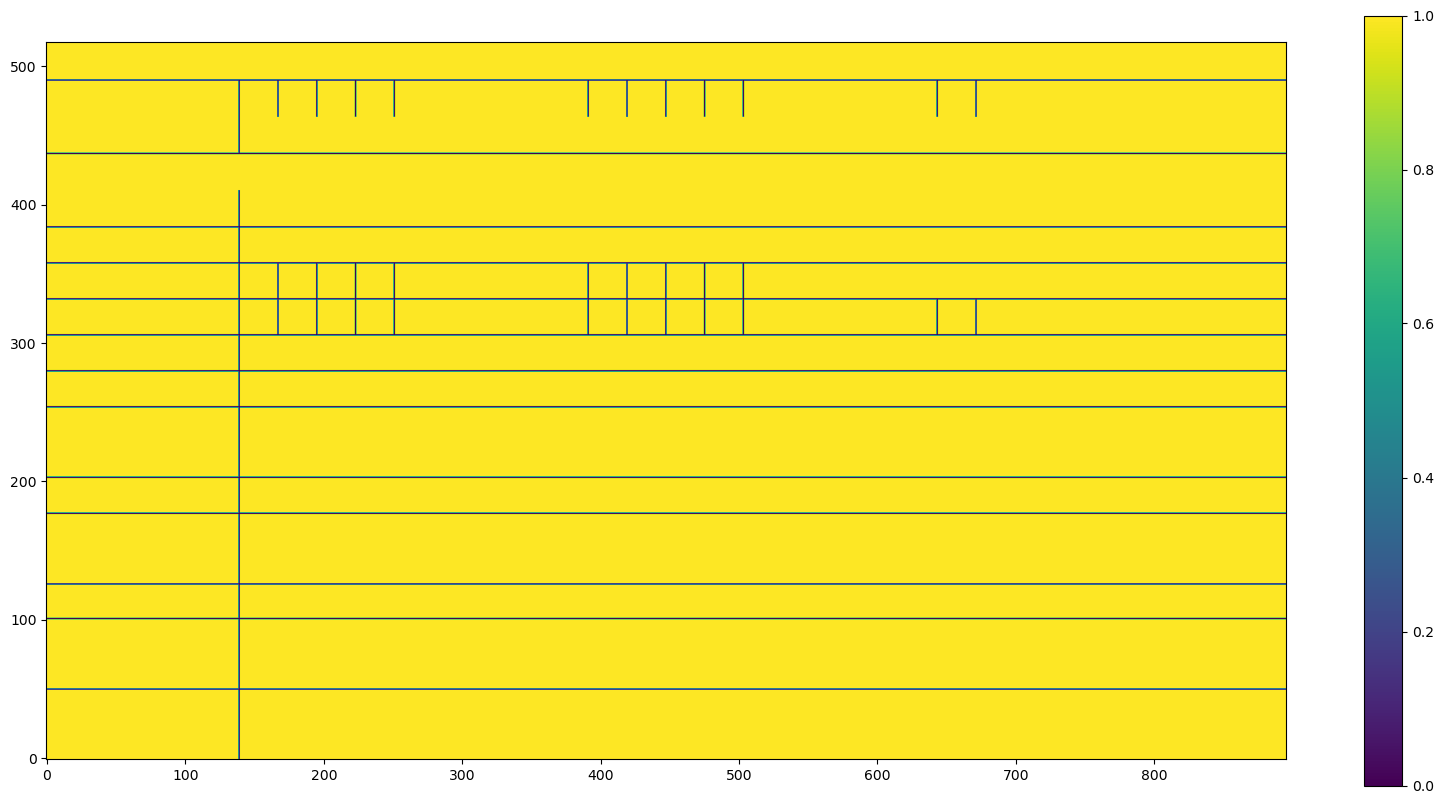

In [15]:
x = Re.__build_alpha_max__()
Re.imshow(x)
print(np.unique(x))

(518, 895)


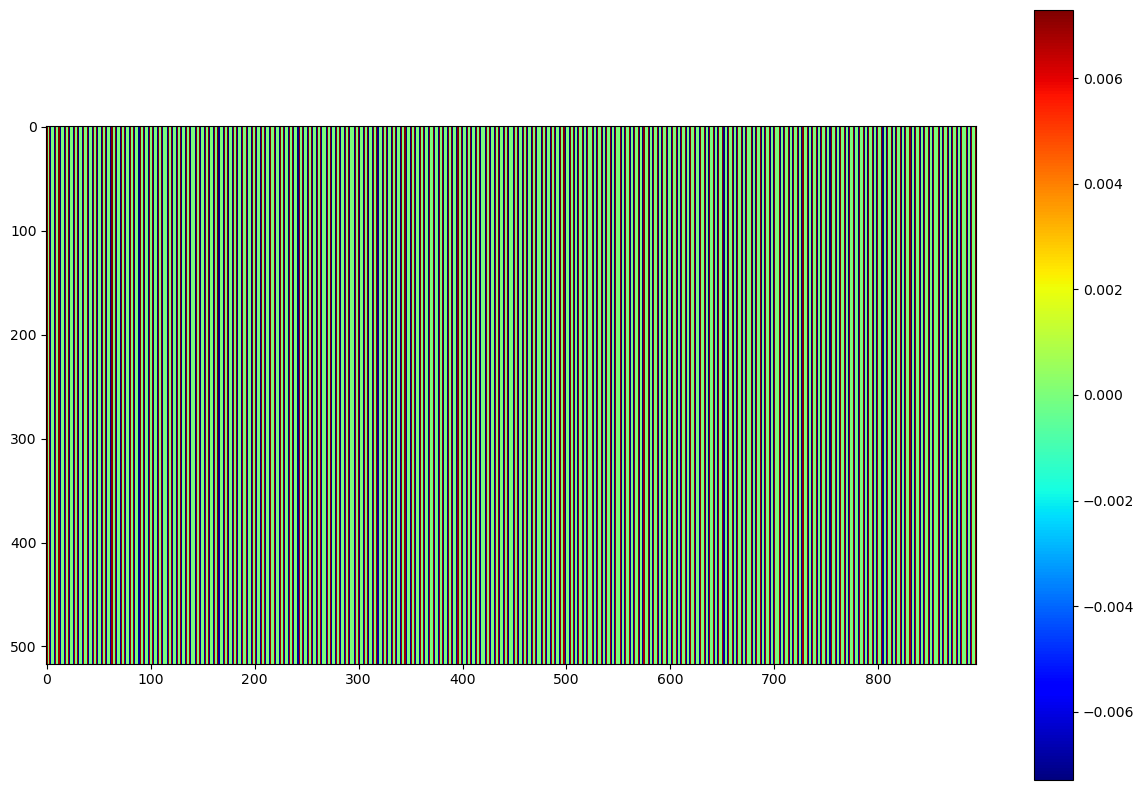

In [16]:
## Plot pixel surface

fig = plt.figure(figsize = (15, 10))    
X = np.diff(Re.pixel_surface, axis = 1)

print(X.shape)
plt.imshow(X[0:517], cmap = 'jet', interpolation='nearest')
plt.colorbar()

In [ ]:
print("Goodbye world !")

Goodbye world !
